In [1]:
import torch
from torch.utils.data import DataLoader
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

from models import BDRE, MDRE, MLP, RatioCritic1D
from IPython.display import display, clear_output

In [2]:
N_DIMS = 1 # Number of dimensions
NUM_SAMPLES = 33000 # Number of samples per distribution (if 3 distributions, then 3 x 33000)
BS = 500 # Batch size
NUM_EPOCHS = 500 # Number of epochs
SEED = 11
LR = 1e-3 # Learning rate
DROPOUT = 0.20
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

tkwargs = {'dtype': torch.float32, 'device': DEVICE}

In [3]:
# Setting seed for reproducibility
# random.seed(SEED)
# torch.manual_seed(SEED)
# np.random.seed(SEED)

In [4]:
from dataset import DistDataset

In [5]:
from torch.distributions.normal import Normal
from torch.distributions.cauchy import Cauchy

def get_dists_1d(mu1=0., mu2=2., mu3=2., scale_p=0.1, scale_q=0.1, scale_m=1.):
    p = Normal(
        loc=mu1,
        scale=scale_p,
    )

    q = Normal(
        loc=mu2,
        scale=scale_q,
    )
    
    m = Cauchy(
        loc=mu3,
        scale=scale_m
    )
    
    return p, q, m

In [6]:
# Define distributions
mu_p = -1.
scale_p = 0.1

mu_q = 1.
scale_q = 0.2

mu_m = 0.
scale_m = 1.0

p, q, m = get_dists_1d(mu1=mu_p, mu2=mu_q, mu3=mu_m, scale_p=scale_p, scale_q=scale_q, scale_m=scale_m)

In [7]:
# Define dataset & dataloader
train_ds = DistDataset(p, q, m, num_samples=NUM_SAMPLES)
test_ds = DistDataset(p, q, m, num_samples=NUM_SAMPLES) # Test dataset is only of size batch 

Sampling p
Sampling q
Cauchy(loc: 0.0, scale: 1.0)
Sampling m
torch.Size([33000])
torch.Size([33000])
torch.Size([33000])
Sampling p
Sampling q
Cauchy(loc: 0.0, scale: 1.0)
Sampling m
torch.Size([33000])
torch.Size([33000])
torch.Size([33000])


In [8]:
# Define dataloader
train_dl = DataLoader(train_ds, batch_size=BS, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=BS, shuffle=True)

In [9]:
x_p = train_ds.get_p_samples()
y_p = torch.empty(x_p.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
x_q = train_ds.get_q_samples()
y_q = torch.empty(x_p.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
x_m = train_ds.get_m_samples()
y_m = torch.empty(x_p.shape[0], dtype=torch.long, device=DEVICE).fill_(2)

In [10]:
# x_train = torch.cat((x_p, x_q)).unsqueeze(-1).to(**tkwargs)
# y_train = torch.nn.functional.one_hot(torch.cat((y_p, y_q))).to(**tkwargs)

# bdre = BDRE(input_dim=1, output_dim=2, **tkwargs)
# bdre.fit(x_train, y_train, batch_size=512*3, S=1000)
# bdre_preds = bdre.predict(x_m.view(-1, 1).to(**tkwargs))

In [11]:
model_cob = MLP(input_dim=N_DIMS, output_dim=3, dropout=DROPOUT).to(**tkwargs)
# Define model
# model_cob = RatioCritic1D(dim_input=N_DIMS, dim_output=3, dropout=DROPOUT).to(DEVICE)

# Define optimizer
optim_cob = torch.optim.Adam(model_cob.parameters(), lr=LR)

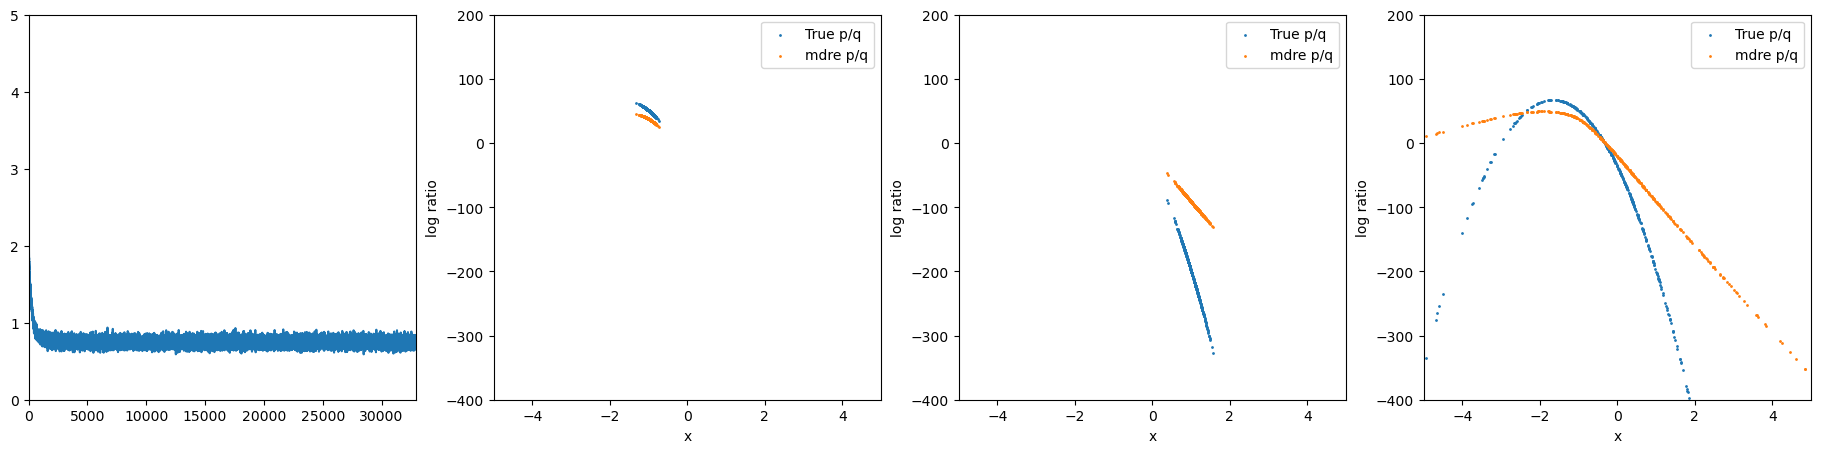

100%|██████████| 500/500 [05:56<00:00,  1.40it/s]


In [12]:
loss_store = []
test_loss_store = []

model_cob.train()

if torch.cuda.is_available():
    model_cob = model_cob.to(DEVICE)
    
i = 0
loss_crit_cob = torch.nn.functional.cross_entropy


for epoch in trange(NUM_EPOCHS):
    for p_batch, q_batch, m_batch in iter(train_dl):
        model_cob.train()
        
        i += 1
        
        optim_cob.zero_grad()
        
        # CUDA
        if torch.cuda.is_available():
            p_batch, q_batch, m_batch = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch.unsqueeze(1).to(DEVICE)
            
        logP = model_cob(p_batch)
        logQ = model_cob(q_batch)
        logM = model_cob(m_batch)
        
        p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
        q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
        m_label = torch.empty(m_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
        
        loss_cob = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM, m_label)
        loss_cob.backward()
        optim_cob.step()
        loss_store.append(loss_cob.item())
            
        # Validation/Test
        if i % 100 == 0:
            model_cob.eval()
            with torch.no_grad():
                for p_batch, q_batch, m_batch in test_dl:
                    gt_log_ratio_p_q = p.log_prob(m_batch) - q.log_prob(m_batch)
                    
                    p_batch, q_batch, m_batch = p_batch.unsqueeze(1).to(DEVICE), q_batch.unsqueeze(1).to(DEVICE), m_batch.unsqueeze(1).to(DEVICE)
    
                    logP = model_cob(p_batch)
                    logQ = model_cob(q_batch)
                    logM = model_cob(m_batch)
    
                    p_label = torch.empty(p_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(0)
                    q_label = torch.empty(q_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(1)
                    m_label = torch.empty(m_batch.shape[0], dtype=torch.long, device=DEVICE).fill_(2)
                    
                    test_loss = loss_crit_cob(logP, p_label) + loss_crit_cob(logQ, q_label) + loss_crit_cob(logM, m_label)
    
                    fig = plt.figure(figsize=(23, 5))
                
                    ax_loss = plt.subplot2grid((1, 4), (0, 0), )
                    ax_loss.plot(range(len(loss_store)), loss_store)
                    ax_loss.set_xlim(0, len(loss_store))
                    ax_loss.set_ylim(0, 5)
                
                    for i, x in enumerate([p_batch, q_batch, m_batch]):
                        ax_dr = plt.subplot2grid((1, 4), (0, i + 1), )
                        ax_dr.scatter(x.cpu(), p.log_prob(x.cpu()) - q.log_prob(x.cpu()), s=1, label='True p/q')
                        mdre_preds = model_cob(x.view(-1, 1)).cpu()
                        ax_dr.scatter(x.cpu(), mdre_preds[:, 0] - mdre_preds[:, 1], s=1, label='mdre p/q')
                        ax_dr.set_xlabel("x")
                        ax_dr.set_ylabel("log ratio")
                        ax_dr.set_xlim(-5, 5)
                        ax_dr.set_ylim(-400, 200)
                        ax_dr.legend();
                
                    clear_output(wait=True)
                    display(fig)
                    plt.close()
                    break

            model_cob.train()

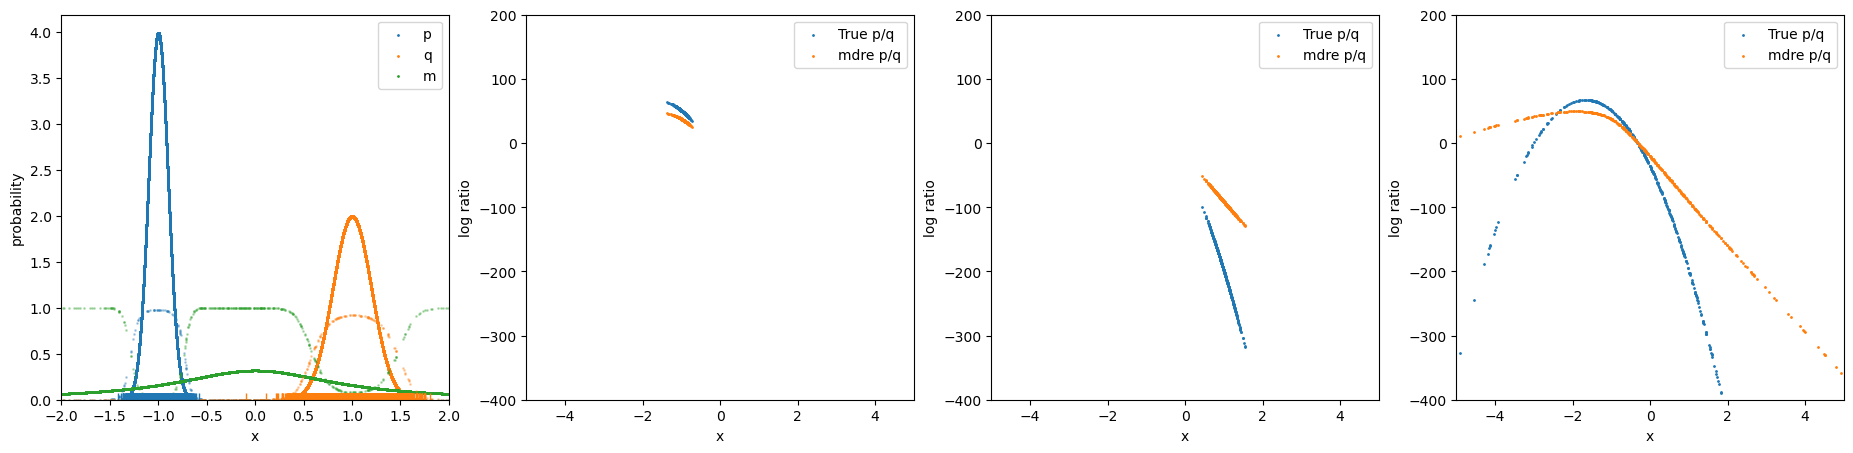

In [16]:
with torch.no_grad():
    model_cob.to("cpu")
    model_cob.eval()
    for p_test, q_test, m_test in test_dl:
    
        fig = plt.figure(figsize=(23, 5))
    
        ax_dist = plt.subplot2grid((1, 4), (0, 0), )
    
        ax_dist.scatter(x_p, p.log_prob(x_p).exp(), s=1, label='p')
        ax_dist.plot(x_p, torch.zeros_like(x_p), '|', markersize=10, color='tab:blue')
        ax_dist.scatter(x_q, q.log_prob(x_q).exp(), s=1, label='q')
        ax_dist.plot(x_q, torch.zeros_like(x_q), '|', markersize=10, color='tab:orange')
        ax_dist.scatter(x_m, m.log_prob(x_m).exp(), s=1, label='m')
    
        mdre_preds = model_cob(m_test.view(-1, 1))
        ax_dist.scatter(m_test, torch.nn.functional.softmax(mdre_preds, dim=1)[:, 0], alpha=0.3, s=1, color='tab:blue')
        ax_dist.scatter(m_test, torch.nn.functional.softmax(mdre_preds, dim=1)[:, 1], alpha=0.3, s=1, color='tab:orange')
        ax_dist.scatter(m_test, torch.nn.functional.softmax(mdre_preds, dim=1)[:, 2], alpha=0.3, s=1, color='tab:green')
    
        ax_dist.set_ylim(0, None)
        ax_dist.set_xlim(-2, 2)
        ax_dist.set_xlabel("x")
        ax_dist.set_ylabel("probability")
        ax_dist.legend()
    
        for i, x in enumerate([p_test, q_test, m_test]):
            ax_dr = plt.subplot2grid((1, 4), (0, i + 1), )
            ax_dr.scatter(x, p.log_prob(x) - q.log_prob(x), s=1, label='True p/q')
            mdre_preds = model_cob(x.view(-1, 1))
            ax_dr.scatter(x, mdre_preds[:, 0] - mdre_preds[:, 1], s=1, label='mdre p/q')
            ax_dr.set_xlabel("x")
            ax_dr.set_ylabel("log ratio")
            ax_dr.set_xlim(-5, 5)
            ax_dr.set_ylim(-400, 200)
            ax_dr.legend();
    
        break